## Synopsis
This code generates the final figure for the SAXS results, including the normalized global scaled SAXS and fits of SAXS at each temperature, using the Lorentian function: 

$$ \large I = \frac{I_{q_0}(T)}{1+(\xi(T) \cdot q)^\eta} $$  

Here, $\xi(T)$ is the characteristic length at temperature $T$, and $I_{q_0}$ corresponds to the SAXS intensity at $q=0$.  

The fitting is done in 3 steps:

1. Use $\eta$ from `SAXS_Scale_Fit`, fit SAXS at every temperature with the Lorentian to determine $I_{q_0}(T)$ and $\xi(T)$.
2. Fit $I_{q_0}(T)$ and $\xi(T)$ over $a \cdot (T-T_0)^b$ to determine the critical temperature $T_0$.
3. Assemble the figure.

### Initialize

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
import csv
from scipy.optimize import minimize
from matplotlib.lines import Line2D

from utils import preprocess_data
from utils import normalize_scaled_curves
from utils import lorentzian_fit
from utils import lorentzian_fit_fix_b
from utils import optimize_T0_log


### Load SAXS data

In [2]:

with open('8IDI_reduced_H06.pickle', 'rb') as f:
    avg_ramp_up = pickle.load(f)
    avg_ramp_down = pickle.load(f)
    t_el = pickle.load(f)
    ql_sta = pickle.load(f)
    ql_dyn = pickle.load(f)

avg_ramp_up_cleaned, ql_sta_cleaned = preprocess_data(avg_ramp_up, ql_sta)

ql = ql_sta_cleaned[0]
num_T = len(ql_sta_cleaned)

I_list = np.zeros((len(ql), len(ql_sta_cleaned)))
for i, (q, data) in enumerate(zip(ql_sta_cleaned, avg_ramp_up_cleaned)):
    I_list[:,i] = data['saxs_1d']


### Fit SAXS at every temperature with the Lorentzian fit of fixed η

In [3]:

# Fit each curve and also extract uncertainties from the covariance matrix.
Iq0 = np.zeros((num_T))
Iq0_err = np.zeros((num_T))
xi = np.zeros((num_T))
xi_err = np.zeros((num_T))

for i in range(num_T):
    popt, pcov = curve_fit(lorentzian_fit_fix_b, q, I_list[:,i], 
                           p0=[np.max(I_list[:,i]), 1],
                           bounds=([0, 0], [np.inf, np.inf]))
    perr = np.sqrt(np.diag(pcov))
    Iq0[i] = popt[0]
    Iq0_err[i] = perr[0]
    xi[i] = popt[1]
    xi_err[i] = perr[1]
    

### (Fig. a) Plot SAXS at every temperature with the Lorentzian fit of fixed η

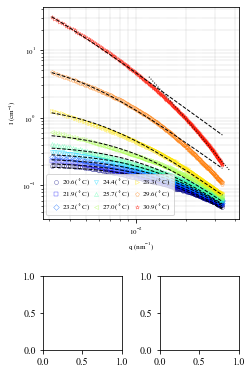

In [4]:

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.size'] = 8
plt.rcParams['figure.dpi'] = 600

figure_width_mm = 86
figure_width_inches = figure_width_mm / 25.4

# --------------------------
# Plotting setup for main figure with 3 subplots
fig = plt.figure(figsize=(figure_width_inches, figure_width_inches * 1.5), constrained_layout=True)
gs = fig.add_gridspec(2, 2, height_ratios=[2, 0.7], width_ratios=[1, 1], hspace=0.1)
ax1 = fig.add_subplot(gs[0, :])  # Subplot (a)
ax2 = fig.add_subplot(gs[1, 0])  # Subplot (b)
ax3 = fig.add_subplot(gs[1, 1])  # Subplot (c)
# Colormap and marker style
cmap = plt.get_cmap('jet')
colors = [cmap(i / num_T) for i in range(num_T)]
marker_styles = ['o', 's', 'D', 'v', '^', '<', '>', 'p', '*']

# Plot I vs. Q at different temperature
for ii in range(num_T):
    ax1.loglog(ql, avg_ramp_up_cleaned[ii]['saxs_1d'], marker_styles[ii % len(marker_styles)], 
               color=colors[ii], markersize=4, markerfacecolor='none', markeredgewidth=0.3)
for jj in range(num_T):
    Iq_fit = lorentzian_fit_fix_b(q, Iq0[jj], xi[jj])
    ax1.loglog(q, Iq_fit, '--', color='black', linewidth=1)

# Add manual curve that shows q scaling at higher q and higher temperature
qx_test = np.logspace(np.log10(1.2e-2), np.log10(3.7e-2), 100)
I_test = lorentzian_fit(qx_test, 5.5e1, 2e2, 2.9)
ax1.loglog(qx_test, I_test, ':', color='black', linewidth=1)

ax1.set_xlabel('q ($\\mathdefault{nm^{-1}}$)', fontsize=7)
ax1.set_ylabel('I (cm$^\\mathdefault{-1}$)', fontsize=7)
ax1.tick_params(axis='both', which='major', labelsize=7)
ax1.grid(which='both', linestyle=':', linewidth=0.4, color='gray')

# Add legend for temperature
t_list = [np.nanmean(avg_dict['temperature']) for avg_dict in avg_ramp_up]
temperatures = np.array(t_list[:-1])
legend_elements = [
    Line2D([0], [0], marker=marker_styles[i % len(marker_styles)], 
           color=colors[i], label=f'{temperatures[i]:.1f}($^\circ$C)',
           markersize=4, linewidth=0.4, linestyle='None', markerfacecolor='none', markeredgewidth=0.3)
    for i in range(num_T)
]
ax1.legend(handles=legend_elements, loc='lower left', fontsize=7, frameon=True, 
           ncol=3, labelspacing=0.3, handletextpad=-0.2, columnspacing=-0.1)
plt.figure(fig)
plt.show()



### Load scaled SAXS data, perform Lorentzian fit with fixed η on the global SAXS curve

In [5]:

with open('SAXS_Global_Scale.pickle', 'rb') as f:
    scaling_results = pickle.load(f)
    scaled_curves = pickle.load(f)

# Normalize the merged data
normalized_q, normalized_i = normalize_scaled_curves(scaled_curves)

# Filter out non-positive values to avoid NaN issues
valid_indices = normalized_q > 0
filtered_x = normalized_q[valid_indices]
filtered_y = normalized_i[valid_indices]

# Fit using scattering function with b fixed
popt, pcov = curve_fit(lorentzian_fit_fix_b, filtered_x, filtered_y, 
                       p0=[np.max(filtered_y), 1], bounds=([0, 0], [np.inf, np.inf]))

Iq0_fit, xi_fit = popt
xi_fit_err = np.sqrt(np.diag(pcov))[1]
extended_x = np.linspace(filtered_x.min(), filtered_x.max(), 500)
fitted_y = lorentzian_fit_fix_b(extended_x, Iq0_fit, xi_fit)
scaled_x = filtered_x * xi_fit
extended_scaled_x = extended_x * xi_fit


### (Fig. a inset) Plot global SAXS curve with the Lorentzian fit of fixed η

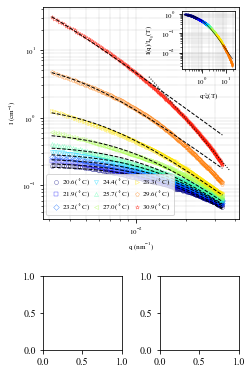

In [6]:

# Inset for Normalized and Fitted Curve in subplot (a)
ax_inset = ax1.inset_axes([0.71, 0.71, 0.27, 0.27])  # Position inset
for i in range(8):
    start_idx = i * 259
    end_idx = (i + 1) * 259
    ax_inset.loglog(scaled_x[start_idx:end_idx], filtered_y[start_idx:end_idx], 'o', 
                    color=colors[i], markersize=0.5)
ax_inset.loglog(extended_scaled_x, fitted_y, color='black', linewidth=0.5)
ax_inset.set_xlabel(r'q$\cdot\mathdefault{\xi(T)}$', fontsize=7)
ax_inset.set_ylabel(r'I(q)/I$\mathdefault{_{q_0}(T)}$', fontsize=7)
ax_inset.tick_params(axis='both', which='major', labelsize=7)
ax_inset.grid(which='both', linestyle=':', linewidth=0.4, color='gray')
plt.figure(fig)
plt.show()
# plt.savefig('./Intermediate_Figures/H06_FigA_Only.pdf', bbox_inches="tight", dpi=600)


In [7]:


best_T0, best_T0_err = optimize_T0_log(temperatures, xi, xi_err, initial_delta=1.0, num_samples=1000)

# --------------------------
# Prepare data for subplots (b) and (c)
T_diff = best_T0 - temperatures

# Fit power laws in log–log space for Iq0 vs (T0-T) and x vs (T0-T)
log_T_diff = np.log(T_diff)
log_Iq0 = np.log(Iq0)
slope_I, intercept_I = np.polyfit(log_T_diff, log_Iq0, 1)
A_I = np.exp(intercept_I)
Iq0_fit_curve = A_I * (T_diff ** slope_I)

log_x = np.log(xi)
slope_x, intercept_x = np.polyfit(log_T_diff, log_x, 1)
A_x = np.exp(intercept_x)
x_fit_curve = A_x * (T_diff ** slope_x)

# Generate smooth curves for plotting.
T_diff_fit = np.linspace(np.min(T_diff), np.max(T_diff), 100)
Iq0_fit_line = A_I * (T_diff_fit ** slope_I)
x_fit_line = A_x * (T_diff_fit ** slope_x)

# Generate smooth curves for plotting.
T_diff_fit = np.linspace(np.min(T_diff), np.max(T_diff), 100)
Iq0_fit_line = A_I * (T_diff_fit ** slope_I)
x_fit_line = A_x * (T_diff_fit ** slope_x)



### Fig. b: $I_{q_0}(T)$ vs. $T_0-T$

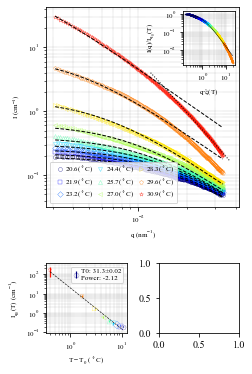

In [8]:


for i in range(len(T_diff)):
    ax2.errorbar(T_diff[i], Iq0[i], yerr=Iq0_err[i]*10, fmt=marker_styles[i % len(marker_styles)], 
                 color=colors[i], markersize=5, markerfacecolor='none', markeredgewidth=0.2, linewidth=0, elinewidth=1.2)
ax2.plot(T_diff_fit, Iq0_fit_line, '--', color='black', linewidth=0.6, label="_nolegend_")
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel(r'$\mathdefault{T-T_0}$ ($^\circ$C)', fontsize=7)
ax2.set_ylabel(r'$\mathdefault{I_{q_0}(T)\ (cm^{-1})}$', fontsize=7)
ax2.tick_params(axis='both', which='major', labelsize=7)
ax2.grid(which='both', linestyle=':', linewidth=0.4, color='gray')
ax2.legend([f'T0: {best_T0:.1f}±{best_T0_err:.2f}\nPower: {slope_I:.2f}'], 
           fontsize=7, frameon=True, handlelength=1, handletextpad=0.3, 
           borderpad=0.2, labelspacing=0.2, loc="upper right")
plt.figure(fig)
plt.show()


### (Fig. c) ζ$(T)$ vs. $T-T_0$

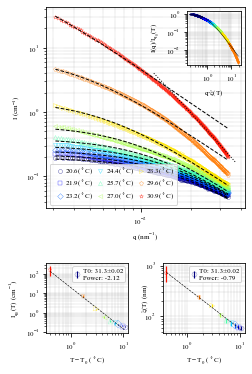

In [9]:

for i in range(len(T_diff)):
    ax3.errorbar(T_diff[i], xi[i], yerr=xi_err[i]*10, fmt=marker_styles[i % len(marker_styles)], 
                 color=colors[i], markersize=5, markerfacecolor='none', markeredgewidth=0.2, linewidth=0, elinewidth=1.2)
ax3.plot(T_diff_fit, x_fit_line, '--', color='black', linewidth=0.6, label="_nolegend_")
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel(r'$\mathdefault{T-T_0}$ ($^\circ$C)', fontsize=7)
ax3.set_ylabel(r'$\mathdefault{\xi(T)\ (nm)}$', fontsize=7)
ax3.tick_params(axis='both', which='major', labelsize=7)
ax3.yaxis.set_label_coords(-0.15, 0.5)
ax3.grid(which='both', linestyle=':', linewidth=0.4, color='gray')
ax3.legend([f'T0: {best_T0:.1f}±{best_T0_err:.2f}\nPower: {slope_x:.2f}'], fontsize=7,  handlelength=1, handletextpad=0.3, 
           borderpad=0.2, labelspacing=0.2, frameon=True)
plt.figure(fig)
plt.show()


### Add labels and save the figure

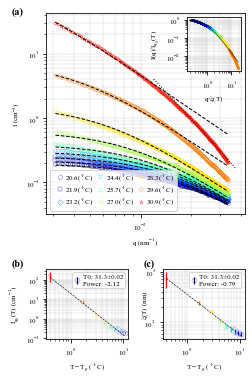

In [10]:
# Add figure labels
fig.text(0.03, 1.01, '(a)', fontsize=10, fontweight='bold', va='top', ha='left')
fig.text(0.03, 0.32, '(b)', fontsize=10, fontweight='bold', va='top', ha='left')
fig.text(0.57, 0.32, '(c)', fontsize=10, fontweight='bold', va='top', ha='left')

plt.figure(fig)
plt.savefig('fitting.pdf', bbox_inches="tight", dpi=600)
plt.show()
